## Supervised Learning:
## Explaining Titanic Hypothesis with Decision Trees

_案例想解决的问题是，根据泰坦尼克号乘客的年龄、等级和性别，确定其是否能生还。_

开始导入numpy, scikit-learn, and pyplot等要用到的Python库，并显示其版本。

In [26]:
import IPython
import sklearn as sk
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import pydot
import pyparsing

print('IPython version:', IPython.__version__)
print('numpy version:', np.__version__)
print('scikit-learn version:', sk.__version__)
print('matplotlib version:', matplotlib.__version__)
print('pydot version:', pydot.__version__)
print('pyparsing version:', pyparsing.__version__)

IPython version: 7.2.0
numpy version: 1.15.4
scikit-learn version: 0.20.1
matplotlib version: 3.0.2
pydot version: 1.4.1
pyparsing version: 2.3.0


### 数据预处理

通常先加载数据集。本案例数据集属性包括：Ordinal, Class, Survived (0=no, 1=yes), Name, Age, Port of Embarkation（登船港）, Home/Destination, Room, Ticket, Boat, and Sex. 设数据存储在下面目录文件中：data/titanic.csv

In [27]:
import csv
with open('data/titanic.csv', 'rt') as csvfile:
    titanic_reader = csv.reader(csvfile, delimiter=',', quotechar='"')
    
    # 首行包含了样本数据的特征名（字段名）
    row = next(titanic_reader)
    feature_names = np.array(row)
    
    # 读入样本数据及其目标字段值
    titanic_X, titanic_y = [], []
    for row in titanic_reader:  
        titanic_X.append(row)
        titanic_y.append(row[2]) # 目标字段名是"survived"，位于第2列（从0开始编号）
    
    titanic_X = np.array(titanic_X)
    titanic_y = np.array(titanic_y)


数据探索：查看数据的格式、形式等（即看看数据长成啥样子） 

In [28]:
print(feature_names, '\n',titanic_X[0],'\n',titanic_y[0])


['row.names' 'pclass' 'survived' 'name' 'age' 'embarked' 'home.dest'
 'room' 'ticket' 'boat' 'sex'] 
 ['1' '1st' '1' 'Allen, Miss Elisabeth Walton' '29.0000' 'Southampton'
 'St Louis, MO' 'B-5' '24160 L221' '2' 'female'] 
 1


案例研究中只需保留：class (1st,2nd,3rd), age (float), and sex (masc, fem)。 

In [29]:
# 保留船舱等级class, 年龄age 和性别sex
titanic_X = titanic_X[:, [1, 4, 10]]
feature_names = feature_names[[1, 4, 10]]
print(feature_names)
print(titanic_X[12], titanic_y[12])

['pclass' 'age' 'sex']
['1st' 'NA' 'female'] 1


年龄字段中有缺失值 ('NA')，可以用年龄平均值来替换。

In [30]:
ages = titanic_X[:, 1]
mean_age = np.mean(titanic_X[ages != 'NA', 1].astype(np.float))
titanic_X[titanic_X[:, 1] == 'NA', 1] = mean_age
print(feature_names) 
print(titanic_X[12], titanic_y[12]) #显示第12条记录，原先age是NA，现用均值31.19替换了


['pclass' 'age' 'sex']
['1st' '31.19418104265403' 'female'] 1


船舱等级class与性别sex是类别型变量，但大多数scikit-learn分类器 (特别是在要用到的决策树中),期望是实数值。我们非常容易将性别转换成二元分类值(0=female,1=male). 我们可以使用scikit-learn中的LabelEncoder类来进行处理:

In [31]:
from sklearn.preprocessing import LabelEncoder
enc = LabelEncoder()
label_encoder = enc.fit(titanic_X[:, 2])                 # 用第2列Sex字段拟合出字符标签值（本例即为两种性别）
print("Categorical classes:", label_encoder.classes_)
integer_classes = label_encoder.transform(label_encoder.classes_)
print("Integer classes:", integer_classes)
t = label_encoder.transform(titanic_X[:, 2])  # 将第2列Sex字段所有值进行数字标签值编码，并存在t中
titanic_X[:, 2] = t   #将第2列替换成数字标记值
print('Feature names:',feature_names)
print('Features for instance number 12:',titanic_X[12], titanic_y[12])

Categorical classes: ['female' 'male']
Integer classes: [0 1]
Feature names: ['pclass' 'age' 'sex']
Features for instance number 12: ['1st' '31.19418104265403' '0'] 1


现在要处理一下船舱等级class字段，因其有3个不同值，所以无法用二元值来替换(而用0/1/2这样的值将会产生一定的次序，这是我们不希望的). 庆幸我们可以用 OneHotEncoder 来处理这种取值多于2个值的类别型变量:

In [32]:
titanic_X[:, 0]

array(['1st', '1st', '1st', ..., '3rd', '3rd', '3rd'], dtype='<U62')

In [33]:
from sklearn.preprocessing import OneHotEncoder

#首先,用label_encoder将字符类别值转换到0-(N-1) 标签值
enc = LabelEncoder()
label_encoder = enc.fit(titanic_X[:, 0])   #第0列，即Pclass字段，取值为（'1st' '2nd' '3rd'）
print("Categorical classes:", label_encoder.classes_)
integer_classes = label_encoder.transform(label_encoder.classes_).reshape(3, 1) #转为3行1列矩阵
print("Integer classes:", integer_classes)

# 然后, 用one_hot_encoder创建一个3列的稀疏矩阵，对应着3个类别值
enc = OneHotEncoder()
one_hot_encoder = enc.fit(integer_classes)

#为titanix_X 创建新特征
num_of_rows = titanic_X.shape[0]
t = label_encoder.transform(titanic_X[:, 0]).reshape(num_of_rows, 1) #构造数字标签值，用样本长度的1列存在t中
new_features = one_hot_encoder.transform(t)  #用one_hot方式构造新特征的稀疏矩阵

# 将构造好的新特征加入到 titanix_X
titanic_X = np.concatenate([titanic_X, new_features.toarray()], axis = 1)
#删除被转换的列
titanic_X = np.delete(titanic_X, [0], 1)
# 更新特征名称
feature_names = ['age', 'sex', 'first_class', 'second_class', 'third_class']
# 转换成数值类型
titanic_X = titanic_X.astype(float)
titanic_y = titanic_y.astype(float)


Categorical classes: ['1st' '2nd' '3rd']
Integer classes: [[0]
 [1]
 [2]]


/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/_encoders.py:368: FutureWarning: The handling of integer data will change in version 0.22. Currently, the categories are determined based on the range [0, max(values)], while in the future they will be determined based on the unique values.
If you want the future behaviour and silence this warning, you can specify "categories='auto'".
In case you used a LabelEncoder before this OneHotEncoder to convert the categories to integers, then you can now use the OneHotEncoder directly.
  warnings.warn(msg, FutureWarning)


In [34]:
print('New feature names:',feature_names)
print('Values:',titanic_X[0])

New feature names: ['age', 'sex', 'first_class', 'second_class', 'third_class']
Values: [29.  0.  1.  0.  0.]


将数据分割成训练集和测试集

In [35]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(titanic_X, titanic_y, test_size=0.25, random_state=33)
X_train, X_test, y_train, y_test

(array([[31.19418104,  1.        ,  0.        ,  0.        ,  1.        ],
        [31.19418104,  0.        ,  1.        ,  0.        ,  0.        ],
        [31.19418104,  1.        ,  0.        ,  0.        ,  1.        ],
        ...,
        [12.        ,  0.        ,  0.        ,  1.        ,  0.        ],
        [18.        ,  1.        ,  0.        ,  1.        ,  0.        ],
        [31.19418104,  0.        ,  0.        ,  0.        ,  1.        ]]),
 array([[18.        ,  1.        ,  0.        ,  1.        ,  0.        ],
        [48.        ,  0.        ,  1.        ,  0.        ,  0.        ],
        [31.19418104,  1.        ,  1.        ,  0.        ,  0.        ],
        ...,
        [20.        ,  1.        ,  0.        ,  0.        ,  1.        ],
        [54.        ,  1.        ,  1.        ,  0.        ,  0.        ],
        [31.19418104,  0.        ,  0.        ,  0.        ,  1.        ]]),
 array([0., 1., 0., 0., 0., 0., 1., 0., 0., 0., 1., 1., 1., 0., 1., 0.

### Decision Trees

现在,我们来创建一个决策树分类器（DecisionTreeClassifier），并用它的fit方法来做学习工作。

In [36]:
from sklearn import tree
#tree.DecisionTreeClassifier?

In [37]:
from sklearn import tree
clf = tree.DecisionTreeClassifier(criterion='entropy', max_depth=3,min_samples_leaf=5)
clf = clf.fit(X_train,y_train)

建立好的决策树代表了一系列基于训练数据的决策。要分类一个样本数据实例，我们需要在每一个节点上回答问题。例如，在根节点，问题是: sex<=0.5? (我们在谈论女性?). 如果答案是yes, 则去树中左边的分支;否则去树的右边分支。你可继续回答问题 (她是3等舱还是一等舱?她小于13岁吗?), 直到你到达叶子节点。当你到达叶节点，会有与之相关的预测目标字段分类值以及最大的实例数 。在本例中，如果她是女性，2等舱，预测结果是1 (that is she survived), 等等。可以用pyplot绘制出决策树:

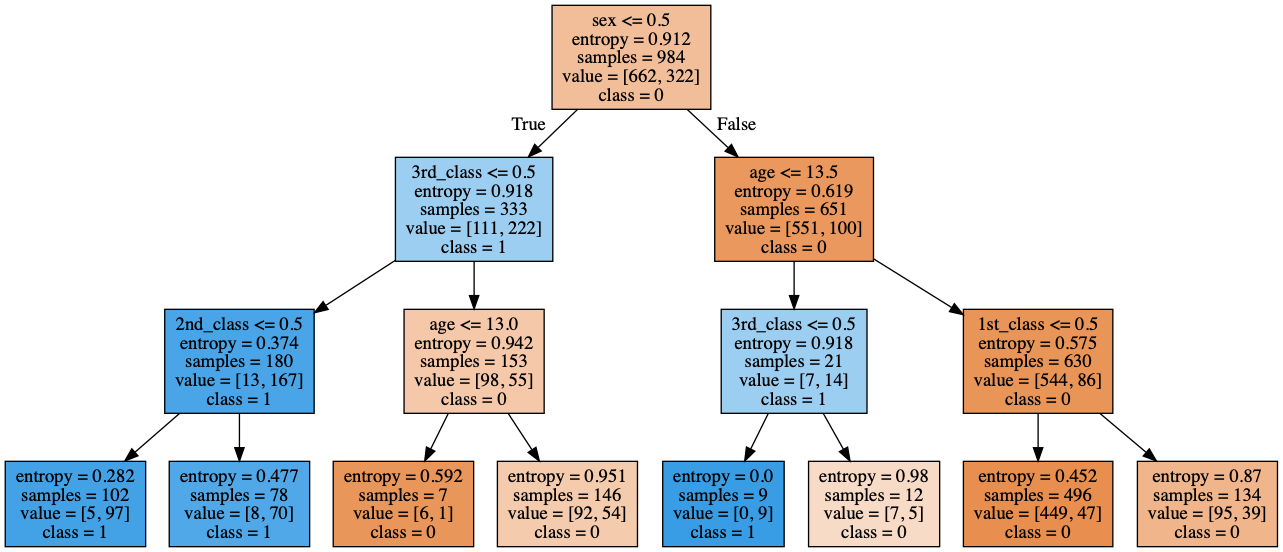

In [39]:
import io,os
dot_data = io.StringIO() 
tree.export_graphviz(clf,out_file=dot_data,filled=True,class_names=['0','1'], feature_names=['age','sex','1st_class','2nd_class','3rd_class']) 
graph = pydot.graph_from_dot_data(dot_data.getvalue()) 

graph[0].write_png('titanic.png') 
from IPython.core.display import Image 
Image(filename='titanic.png')

分类算法学习完需要评估。评估指标有准确度，精确度，召回率，F1（accuracy, precision, recall, f1）

In [22]:
from sklearn import metrics
def measure_performance(X,y,clf, show_accuracy=True, show_classification_report=True, show_confusion_matrix=True):
    y_pred=clf.predict(X)   
    if show_accuracy:
        print("Accuracy:{0:.3f}".format(metrics.accuracy_score(y,y_pred)),"\n")

    if show_classification_report:
        print("Classification report")
        print(metrics.classification_report(y,y_pred),"\n")
        
    if show_confusion_matrix:
        print("Confusion matrix")
        print(metrics.confusion_matrix(y,y_pred),"\n")
        
measure_performance(X_train,y_train,clf, show_classification_report=False, show_confusion_matrix=True)

Accuracy:0.838 

Confusion matrix
[[649  13]
 [146 176]] 



In [24]:
y_pred=clf.predict(titanic_X) 
y_pred

array([1., 1., 0., ..., 0., 0., 0.])